In [2]:
import numpy as np
import matplotlib.pyplot as plt

[[  0.00000000e+00   2.39600000e+03   5.28400000e+03]
 [  1.00000000e+00   2.65600000e+03   2.93800000e+03]
 [  2.00000000e+00   4.12000000e+03   2.27800000e+03]
 [  3.00000000e+00   4.34200000e+03   1.02000000e+02]
 [  4.00000000e+00   4.38400000e+03   2.98800000e+03]
 [  5.00000000e+00   5.13600000e+03   2.28000000e+03]
 [  6.00000000e+00   6.63400000e+03   5.41600000e+03]
 [  7.00000000e+00   8.59800000e+03   2.63200000e+03]
 [  8.00000000e+00   8.89800000e+03   4.17000000e+03]
 [  9.00000000e+00   1.17380000e+04   1.55000000e+03]]


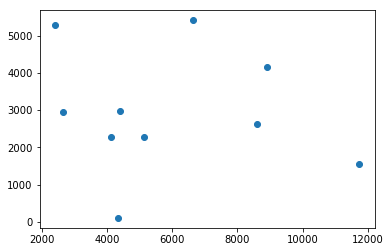

In [10]:
data_pts = np.loadtxt('challenge_instances/data/images/euro-night-0000010.instance')
# data_pts = np.loadtxt('challenge_instances/data/images/us-night-0000020.instance')

print(data_pts)

plt.scatter(data_pts[:, 1], data_pts[:, 2])
plt.show()

In [11]:
## u,v: both [1x3] with columns [id, x, y]
def perpdot(u, v):
    return u[1]*v[2] - u[2]*v[1]

## function to compute area as integer (loop computes twice the area)
## pts: [nx3] columns are [id, x, y], 
##      auto completes path (loops back to beginning)
def area(pts):
    N = len(pts)
    twicearea = perpdot(pts[0],pts[N-1])
    for i in range(1, N):
        twicearea += perpdot(pts[i],pts[i-1])
    return abs(twicearea / 2)

def area_tri(pt0, pt1, pt2):
    return area(np.array([pt0, pt1, pt2]))

In [12]:
pts_test = np.array([[0, 2],
                     [2, 0],
                     [0, 0]])
print(area(pts[:3]))

# sanity check
a = pts[0]
b = pts[1]
c = pts[2]
# a = pts_test[0]
# b = pts_test[1]
# c = pts_test[2]
print( abs((a[1]*(b[2]-c[2]) + b[1]*(c[2]-a[2]) + c[1]*(a[2]-b[2])) / 2) )
print( area_tri(a, b, c) )

NameError: name 'pts' is not defined

In [13]:
def ccw(A,B,C):
    return (C[2]-A[2]) * (B[1]-A[1]) > (B[2]-A[2]) * (C[1]-A[1])

# Return true if line segments AB and CD intersect
def intersect(A,B,C,D):
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

#  compute whether triangle [C1, C2, D] intersects with any
#      segment in p
def tri_path_intersect(p, C1, C2, D):
    for i in range(len(p)):
        A = p[i]
        B = p[(i+1) % len(p)]
        if A[0] != C1[0] and B[0] != C1[0]:
            if intersect(A, B, C1, D):
                return True
        if A[0] != C2[0] and B[0] != C2[0]:
            if intersect(A, B, C2, D):
                return True
    return False

In [14]:
## pts: [nx3] columns [id, x, y]
def build_triangulation(pts):
#     pts_tup = tuple(pts)
    
    N = len(pts)
    P = pts[:, 0].astype(int)
#     print(len(P))
    
    # construct initial smallest tri
    start = pts[0]
    start_min_area = np.inf
    path = [start]
    for i in range(1, N):
        for j in range(1, N):
            if i != j:
                a = area_tri(start, pts[i], pts[j])
                if a < start_min_area:
                    start_min_area = a
                    if len(path) > 1:
                        path = [path[0]]
#                         P = set([0])
                    path.extend([pts[i], pts[j]])
    
    # iteratively add smallest tris
    P_path = np.array(path)[:, 0].astype(int)  # point ids in path
    while len(P_path) < N:
        plt_path = np.asarray(path + [path[0]])
        plt.plot(plt_path[:, 1], plt_path[:, 2])
        plt.scatter(data_pts[:, 1], data_pts[:, 2])
        plt.show()
        
        free_pts = np.setdiff1d(P, P_path)  # point ids not yet visited
        print(free_pts)
        print(P_path)
        
        min_area = np.inf
        min_i = 0
        min_j = -1
        for i in range(len(P_path)):
            id1 = P_path[i]
            id2 = P_path[(i+1) % len(P_path)]
            i_min_area = np.inf
            id3_min_area = 0
            for j in free_pts:
                if not tri_path_intersect(path, pts[id1], pts[id2], pts[j]):
                    a = area_tri(pts[id1], pts[id2], pts[j])
                    if a < i_min_area:
                        i_min_area = a
                        id3_min_area = j
            if i_min_area < min_area:
                min_area = i_min_area
                min_i = i
                min_j = id3_min_area
        
        # add smallest tri to path
        if min_j != -1:
            path.insert(min_i+1, pts[min_j])
            P_path = np.array(path)[:, 0].astype(int)  # point ids in path
        else:
            print(tri_path_intersect(path, pts[0], pts[9], pts[6]))
            plt_path = np.asarray(path + [path[0]])
            plt.plot(plt_path[:, 1], plt_path[:, 2])
            plt.plot(data_pts[[0, 6, 9], 1], data_pts[[0, 6, 9], 2])
            plt.scatter(data_pts[:, 1], data_pts[:, 2])
            plt.show()
            raise Exception('couldnt find tri to add')
        
        
    plt_path = np.asarray(path + [path[0]])
    plt.plot(plt_path[:, 1], plt_path[:, 2])
    plt.scatter(data_pts[:, 1], data_pts[:, 2])
    plt.show()
    print(len(P_path), N)
    
    # add initial pt to terminate path
    path.append(path[0])
    return np.asarray(path)


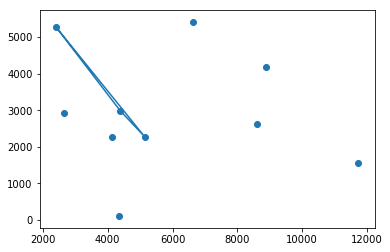

[1 2 3 6 7 8 9]
[0 4 5]


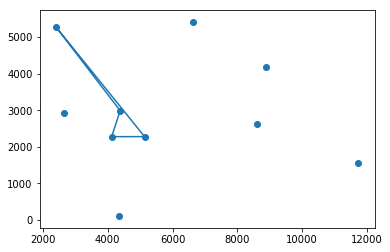

[1 3 6 7 8 9]
[0 4 2 5]


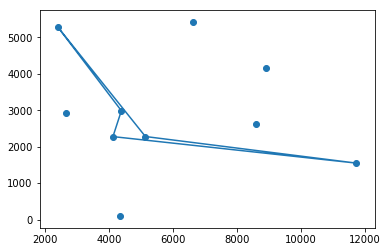

[1 3 6 7 8]
[0 4 2 9 5]


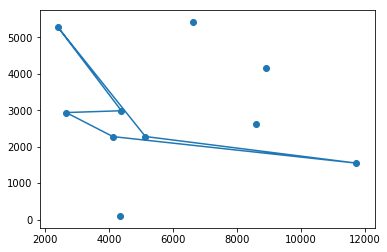

[3 6 7 8]
[0 4 1 2 9 5]


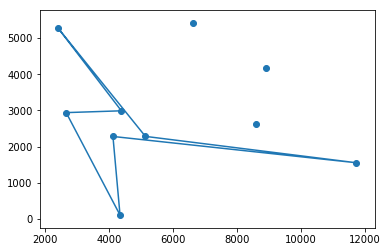

[6 7 8]
[0 4 1 3 2 9 5]


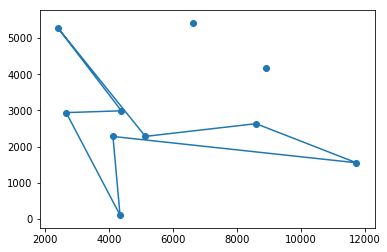

[6 8]
[0 4 1 3 2 9 7 5]


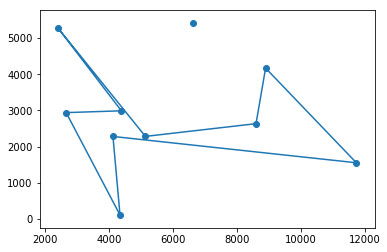

[6]
[0 4 1 3 2 9 8 7 5]


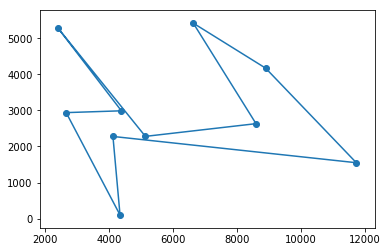

10 10
11 9954272.0 [[  0.00000000e+00   2.39600000e+03   5.28400000e+03]
 [  4.00000000e+00   4.38400000e+03   2.98800000e+03]
 [  1.00000000e+00   2.65600000e+03   2.93800000e+03]
 [  3.00000000e+00   4.34200000e+03   1.02000000e+02]
 [  2.00000000e+00   4.12000000e+03   2.27800000e+03]
 [  9.00000000e+00   1.17380000e+04   1.55000000e+03]
 [  8.00000000e+00   8.89800000e+03   4.17000000e+03]
 [  6.00000000e+00   6.63400000e+03   5.41600000e+03]
 [  7.00000000e+00   8.59800000e+03   2.63200000e+03]
 [  5.00000000e+00   5.13600000e+03   2.28000000e+03]
 [  0.00000000e+00   2.39600000e+03   5.28400000e+03]]


In [15]:
p = build_triangulation(data_pts)
print(len(p), area(p[:-1]), p)

# p_poly = path
# plt.plot(p[:, 1], p[:, 2])
# plt.scatter(data_pts[:, 1], data_pts[:, 2])
# plt.show()